In [1]:
%reset
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import minimize,curve_fit
from lmfit import Model
import convolutionF as F
import numba
from numba import autojit
from numba import cuda
from numba import *
from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
import time
from pylab import genfromtxt;

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
mcvineSol_0='/home/fi0/simulations/ARCS/powder-res-demo_0/res-sim/iqe.h5' ## IQE from Mcvine
mcvineSol_50='/home/fi0/simulations/ARCS/powder-res-demo_50/res-sim/iqe.h5' ## IQE from Mcvine
mcvineSol_100='/home/fi0/simulations/ARCS/powder-res-demo_1/res-sim/iqe.h5' ## IQE from Mcvine
mcvineSol_150='/home/fi0/simulations/ARCS/powder-res-demo_150/res-sim/iqe.h5' ## IQE from Mcvine
mcvineSol_200='/home/fi0/simulations/ARCS/powder-res-demo_200/res-sim/iqe.h5' ## IQE from Mcvine
mcvineSol_250='/home/fi0/simulations/ARCS/powder-res-demo_250/res-sim/iqe.h5' ## IQE from Mcvine

In [3]:
RF_0= hh.load(mcvineSol_0)
RF_50= hh.load(mcvineSol_50)
RF_100= hh.load(mcvineSol_100)
RF_150= hh.load(mcvineSol_150)
RF_200= hh.load(mcvineSol_200)
RF_250= hh.load(mcvineSol_250)
# plt.figure()
# H.plot(RF, min=0)

/home/fi0/anaconda2/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [4]:
ie_0 = RF_0[(10,14), (-50,298)].sum('Q')
ie_50 = RF_50[(10,14), (-50,298)].sum('Q') ## simulatede DOS 
ie_100 = RF_100[(10,14), (-50,298)].sum('Q')
ie_150 = RF_150[(10,14), (-50,298)].sum('Q')
ie_200 = RF_200[(10,14), (-50,298)].sum('Q')
ie_250 = RF_250[(10,14), (-50,298)].sum('Q')

ie_0.I[np.isnan(ie_0.I)] = 0
ie_50.I[np.isnan(ie_50.I)] = 0
ie_100.I[np.isnan(ie_100.I)] = 0
ie_150.I[np.isnan(ie_150.I)] = 0
ie_200.I[np.isnan(ie_200.I)] = 0
ie_250.I[np.isnan(ie_250.I)] = 0




<IPython.core.display.Javascript object>


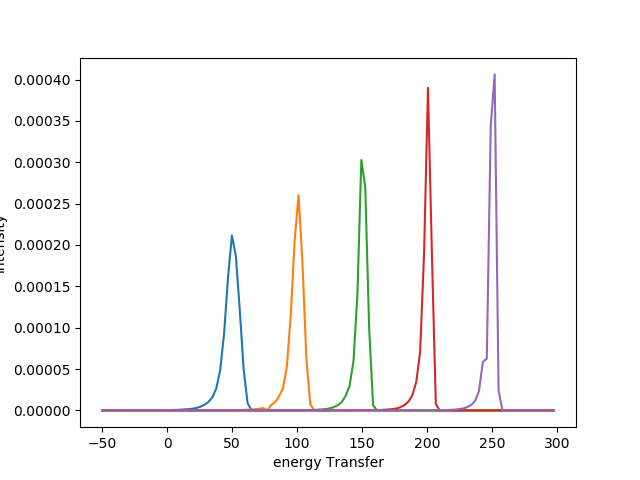

In [5]:
g = globals()
num_energy = np.arange(50,300,50)
x = ie_50.E
RFB=np.zeros((len(num_energy),len(x))) # initializing point spread function

plt.figure('from mcvine')
for i,j in zip (num_energy, xrange(len(num_energy))):
    RFB[j,:]=g['ie_{}'.format(i)].I
    plt.plot(x,RFB[j,:])
plt.xlabel('energy Transfer')
plt.ylabel('intensity')
plt.show()


<IPython.core.display.Javascript object>


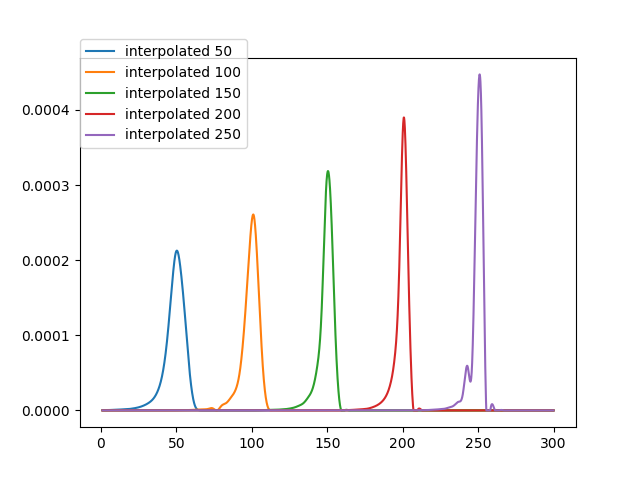

In [6]:

RFBnew = interp1d(x, RFB,fill_value='extrapolate', kind='cubic')
EnerInt = np.arange(1, 300, 0.1)
RFBnew_=RFBnew(EnerInt)
RFBnew_[RFBnew_<0]=0

plt.figure('after interpolation and making negative zeros')
for i in xrange(RFBnew_.shape[0]):
    plt.plot(EnerInt,RFBnew_[i,:], label='interpolated {}'.format(num_energy[i]))
plt.legend(bbox_to_anchor=(0.001, 1.05), loc=2, borderaxespad=0)
plt.show()




In [7]:
def Count(tm,R,a,b,s,t0,A):
    ul= ((1/(np.sqrt(2)*s))*(((11.6*tm)/16.6)-t0))

    vl_a= (ul+((a/np.sqrt(2))*((s*16.6)/(2.+3.))))
    
    vl_b= (ul+((b/np.sqrt(2))*((s*16.6)/(2.+3.))))

    C01l= (np.sqrt(np.pi/2)*((s*16.6)/(2.+3.))*np.exp(vl_b**2-ul**2)*erfc(vl_b))
    C02l= (np.sqrt(np.pi/2)*((s*16.6)/(2.+3.))*np.exp(vl_a**2-ul**2)*erfc(vl_a))

    C1l= (((s*16.6)/(2.+3.))**2*np.exp(vl_a**2-ul**2)*(np.exp(-vl_a**2)-(np.sqrt(np.pi)*vl_a*erfc(vl_a))))

    C2l= (np.sqrt(2)*((s*16.6)/(2.+3.))**3*np.exp(vl_a**2-ul**2)*((np.sqrt(np.pi)*(.5+vl_a**2)*erfc(vl_a))-(vl_a*np.exp(-vl_a**2))))
    return ((A/(16.6*np.sqrt(2*np.pi)*s))*(((1-R)*a**2*C2l)+((R*a**2*b/(a-b)**3)*((2*C01l)-(((a-b)**2*C2l)+(2*(a-b)*C1l)+(2*C02l))))))


In [8]:
def lamda(Ei):
    Ej=Ei*1.6021*10**-22
    h_js=6.626*10**-34
    m_kg=1.674929*10**-27
    lam=h_js/np.sqrt(2*Ej*m_kg)
    return (lam)

Ei=300.
l3=3.
a0=1.6
a1=1.5
b0=31.9
k=46
a_cal=1./(a0+(lamda(Ei)*a1))
b_cal=1/b0
R_cal=np.exp(-81.799/(k*lamda(Ei)**2))
A_fixed=1
s_fixed=1

R_fit=[]
a_fit=[]
b_fit=[]
s_fit=[]
t0_fit=[]
A_fit=[]


<IPython.core.display.Javascript object>


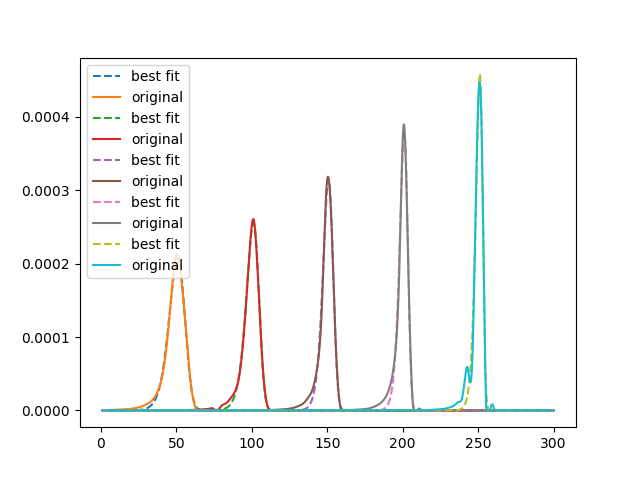

In [13]:
def vFrmE(E):
    Ej=E*1.6021*10**-22
    m=1.674929*10**-27
    v=np.sqrt((2.*Ej)/m)
    return(v)

def t(l3,Ei,Et,Ep): 
    Ef=Ei-Et 
    T=(-(l3/vFrmE(Ef))+(l3/np.sqrt(vFrmE(Ei)**2-vFrmE(Ep)**2)))*1e6 
    return (T)
t0=-10 #0
t1=1 #4
t2=1 #1
t3=25
t4=180
t5=1

plt.figure('fitting the data')
for i in xrange(num_energy.shape[0]):
    Ep = np.arange(num_energy[i]-25.,num_energy[i]+25., (25.*2.)/2990.)
    tp=t(l3,Ei,num_energy[i],Ep)
    t_cal=abs(tp[tp.shape[0]-1])-abs(tp[0])
    mod = Model(Count)
    mod.set_param_hint('R', value=R_cal, min=0.0)
    mod.set_param_hint('a', value=a_cal, min=0.0)
    mod.set_param_hint('b', value=b_cal, min=0.0)
    mod.set_param_hint('s', value=s_fixed, min=0.0)
    mod.set_param_hint('t0', value=g['t{}'.format(i)])
    mod.set_param_hint('A', value=A_fixed, min=0.0)
#     pars= mod.make_params( R=R_cal,a=a_cal,b=b_cal,s=s_fixed,t0=g['t{}'.format(i)], A=A_fixed)
    pars= mod.make_params()
    result = mod.fit(RFBnew_[i,:], pars, tm=tp, fit_kws={'nan_policy': 'omit'})

    
    R_fit.append(result.params['R'].value)
    a_fit.append(result.params['a'].value)
    b_fit.append(result.params['b'].value)
    s_fit.append(result.params['s'].value)
    t0_fit.append(result.params['t0'].value)
    A_fit.append(result.params['A'].value)
    
    

    plt.plot(EnerInt, result.best_fit,'--', label='best fit')
    plt.plot(EnerInt, RFBnew_[i,:], label='original')
    plt.legend()
plt.show()




In [10]:

R_intp = interp1d(num_energy, R_fit,fill_value='extrapolate', kind='cubic')
a_intp = interp1d(num_energy, a_fit,fill_value='extrapolate', kind='cubic')
b_intp = interp1d(num_energy, b_fit,fill_value='extrapolate', kind='cubic')
s_intp = interp1d(num_energy, s_fit,fill_value='extrapolate', kind='cubic')
t0_intp = interp1d(num_energy, t0_fit,fill_value='extrapolate', kind='cubic')
A_intp = interp1d(num_energy, A_fit,fill_value='extrapolate', kind='cubic')

<IPython.core.display.Javascript object>


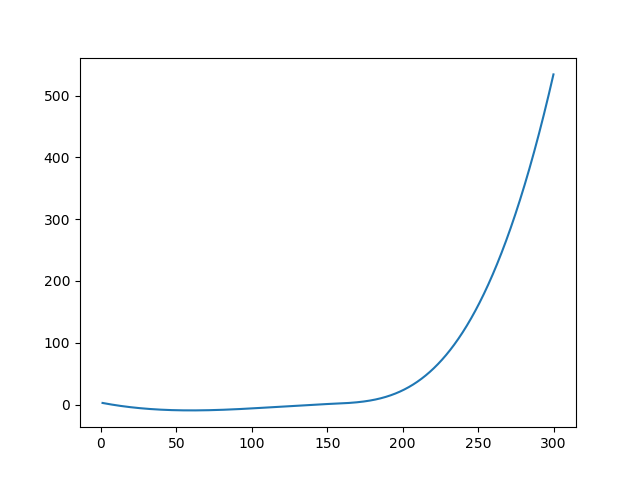

In [11]:
plt.figure()
plt.plot(EnerInt,t0_intp(EnerInt))
plt.show()

<IPython.core.display.Javascript object>


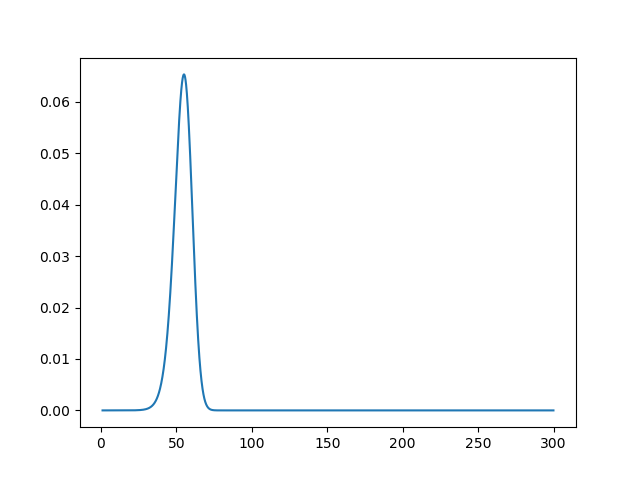

In [12]:
Et=40
Echeck = np.arange(Et-25.,Et+25., (25.*2.)/2990.)
tcheck=t(l3,Ei,Et,Echeck)


check=Count(tcheck,R_intp(Et),a_intp(Et),b_intp(Et),s_intp(Et),t0_intp(Et),A_fixed)


plt.figure()
plt.plot(EnerInt,check, label='inter')
plt.show()